In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os,shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [141]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")

All modules have been imported


In [ ]:
from pynvml import *
import time
from IPython.display import clear_output

nvmlInit()
ngpus = nvmlDeviceGetCount()
while True:
    time.sleep(2)
    clear_output(wait=True)
    for i in range(ngpus):
        handle = nvmlDeviceGetHandleByIndex(i)
        gpu_util = nvmlDeviceGetUtilizationRates(handle).gpu
        print("GPU %d Utilization = %d%%" % (i, gpu_util))


In [230]:
import zipfile

z=zipfile.ZipFile('archive.zip')
z.extractall()

In [ ]:
#Dataset


In [235]:
!apt-get install tree

# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/bin/bash: tree: command not found


In [236]:
IMG_PATH = "Brain_Tumor_Detection"

# split the data by train/val/test
ignored = {"pred"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 300:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.8*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [237]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [238]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

In [239]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)


100%|██████████| 2/2 [00:25<00:00, 12.66s/it]
/tmp/ipykernel_4260/4020615754.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



1800 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


600 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]

600 images loaded from VAL/ directory.


In [144]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [240]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

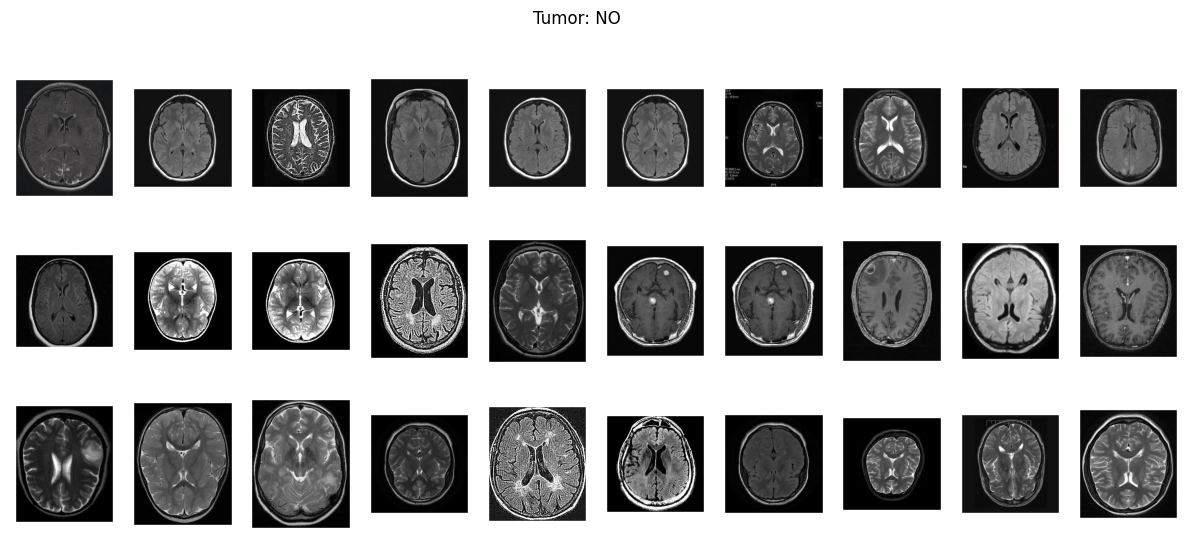

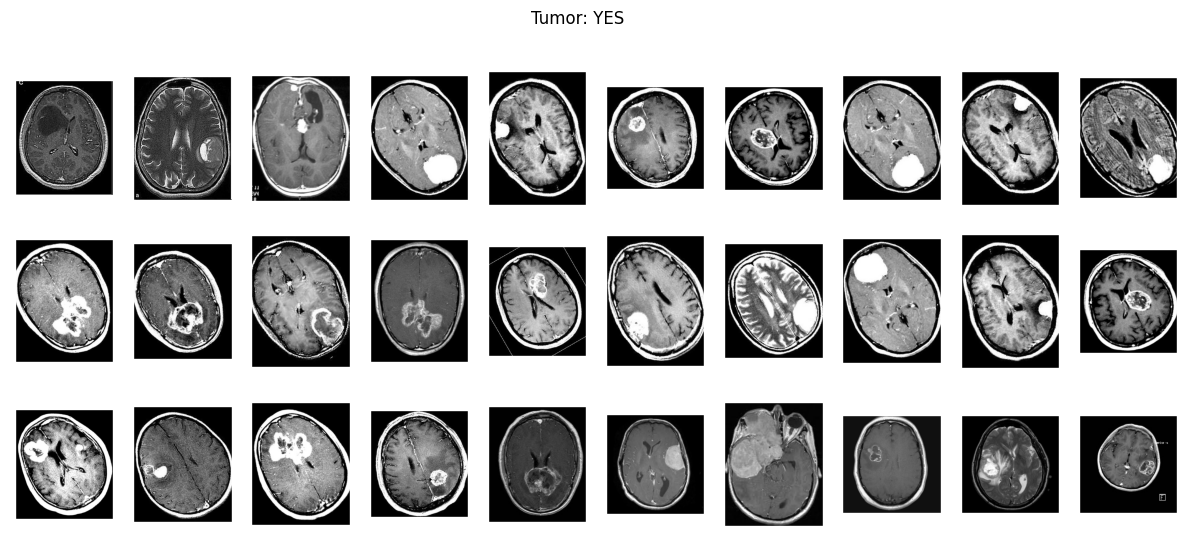

In [241]:
plot_samples(X_train, y_train, labels, 30)

In [242]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [244]:
import imutils
img = cv2.imread('VAL/NO/no852.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

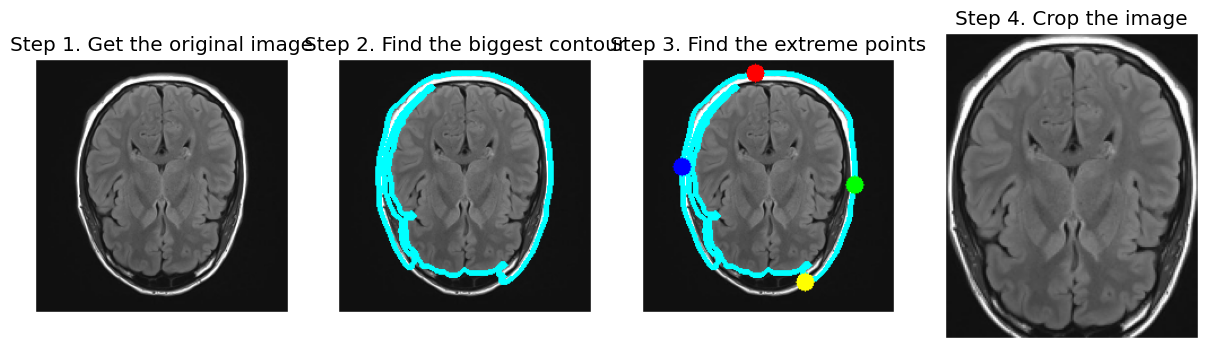

In [245]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [246]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/tmp/ipykernel_4260/2254567846.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



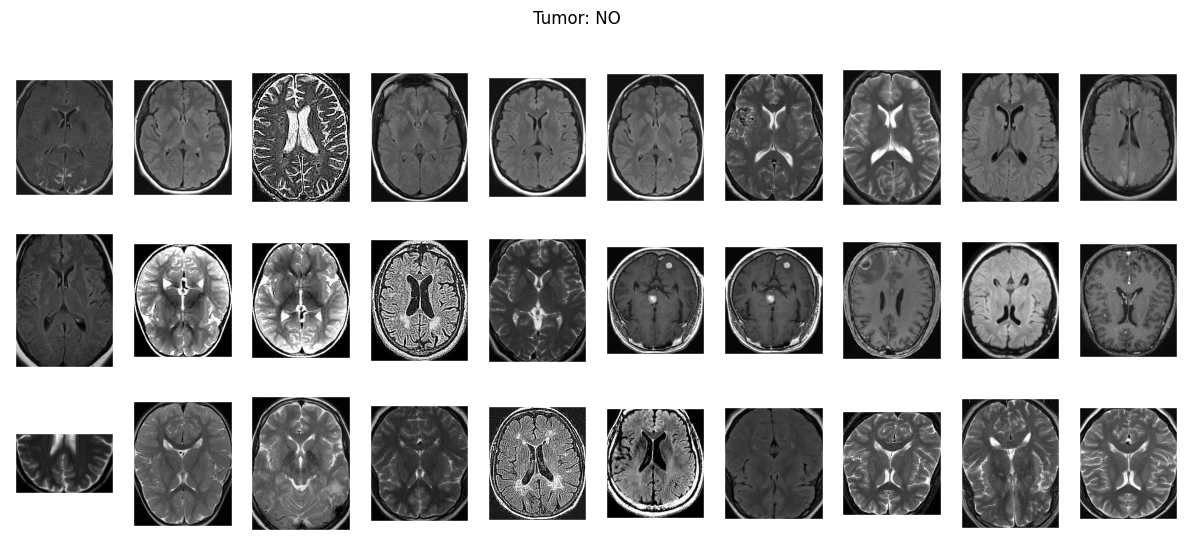

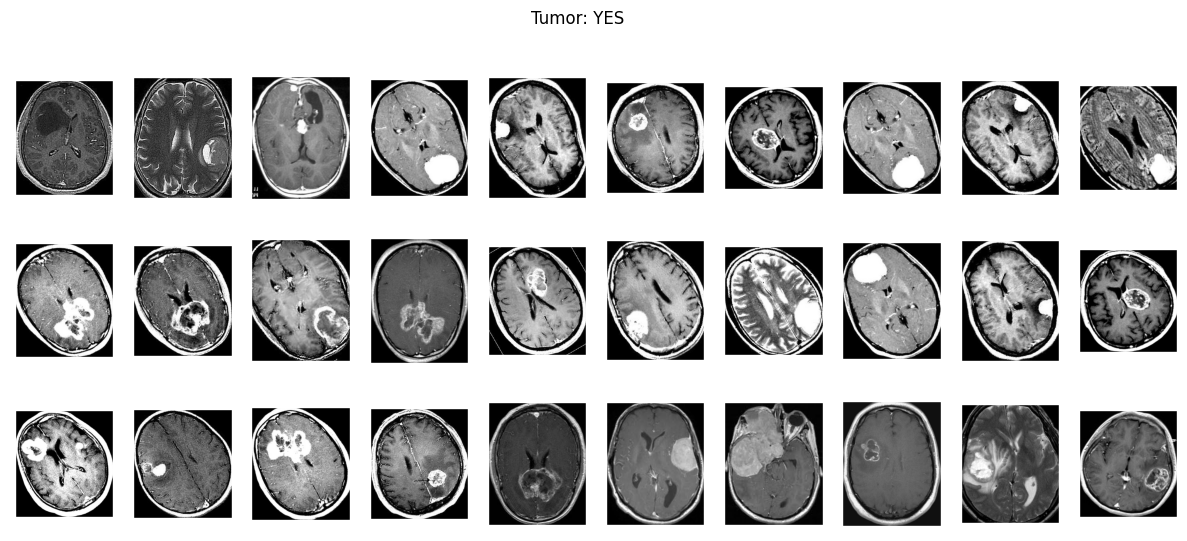

In [247]:
plot_samples(X_train_crop, y_train, labels, 30)

In [248]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [250]:
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

In [251]:
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [252]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)


In [253]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

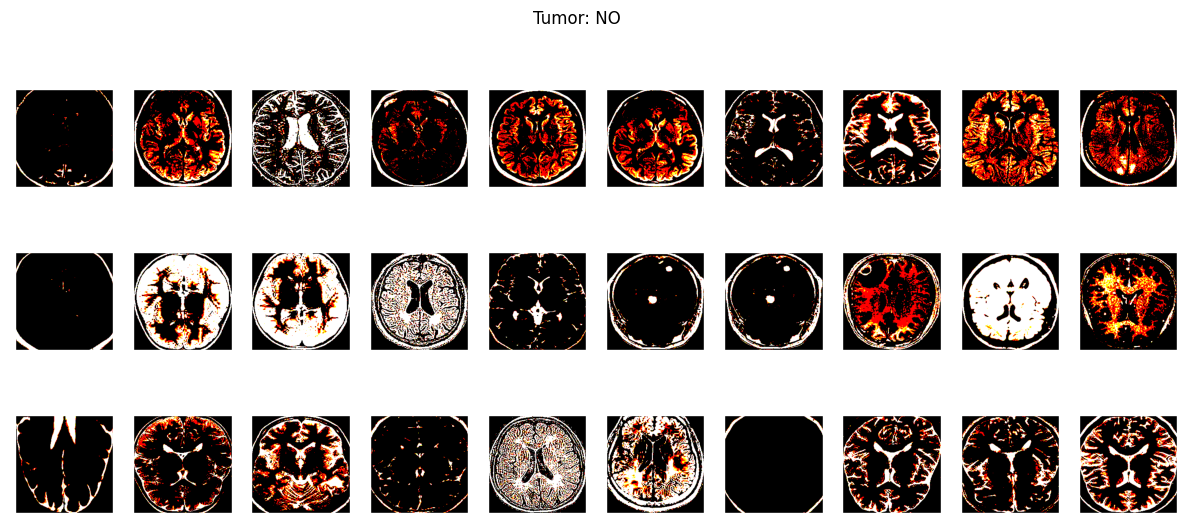

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

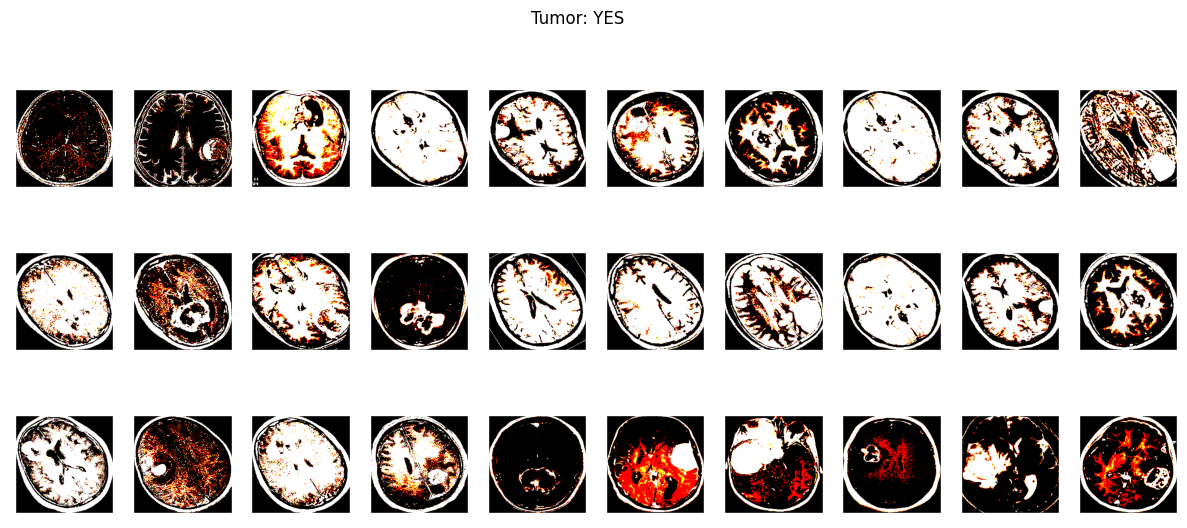

In [254]:
plot_samples(X_train_prep, y_train, labels, 30)

In [255]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
   
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [256]:
base_Neural_Net= VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

    
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,548,801 (101.28 MB)

 Trainable params: 6,473,729 (24.70 MB)

 Non-trainable params: 20,075,072 (76.58 MB)

In [257]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)
filepath='model.keras'
cp=ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False,mode='auto',save_freq='epoch')
lrr=ReduceLROnPlateau(monitor='val_accuracy', patience=3,verbose=1,factor=0.5,min_lr=0.0001)
history = model.fit(
    train_generator,
  
    epochs=EPOCHS,
    validation_data=validation_generator,
   
    callbacks=[es,cp,lrr]
)

/anaconda/envs/my_new_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - AUC: 0.8208 - accuracy: 0.7425 - loss: 0.6738
Epoch 1: val_loss improved from inf to 2.49161, saving model to model.keras


/anaconda/envs/my_new_env/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning:

Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss



57/57 ━━━━━━━━━━━━━━━━━━━━ 59s 984ms/step - AUC: 0.8221 - accuracy: 0.7439 - loss: 0.6703 - val_AUC: 0.8477 - val_accuracy: 0.7550 - val_loss: 2.4916 - learning_rate: 0.0010
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - AUC: 0.9553 - accuracy: 0.9013 - loss: 0.2666
Epoch 2: val_loss improved from 2.49161 to 0.99538, saving model to model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - AUC: 0.9554 - accuracy: 0.9013 - loss: 0.2663 - val_AUC: 0.9045 - val_accuracy: 0.8317 - val_loss: 0.9954 - learning_rate: 0.0010
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - AUC: 0.9752 - accuracy: 0.9089 - loss: 0.2070
Epoch 3: val_loss improved from 0.99538 to 0.52343, saving model to model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 57s 999ms/step - AUC: 0.9752 - accuracy: 0.9090 - loss: 0.2069 - val_AUC: 0.9529 - val_accuracy: 0.8767 - val_loss: 0.5234 - learning_rate: 0.0010
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - AUC: 0.9809 - accuracy: 0.9397 - loss: 0.1729
Epoch 4: val_loss did

KeyboardInterrupt: 

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step
Test Accuracy = 0.98


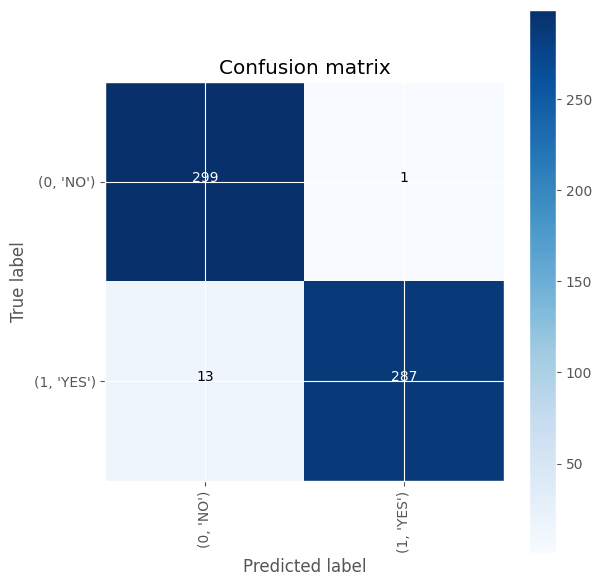

In [258]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('model.keras')

# Generate predictions using the test generator
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [261]:
L=[]
test='TEST_CROP/YES/'
for img in os.listdir(test):
    img = cv2.imread(test+img)
    resized_image = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    resized_image = np.expand_dims(resized_image, axis=0)  # Shape becomes (1, 240, 240, 3)
    predictions = model_01.predict(resized_image)
    if  predictions[0][0] <= 0.5:
        L.append(0)
    else:
       L.append(1) 
print(L)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [264]:
L.count(1)

245

In [ ]:
folder ='Data/meningioma_tumor/'
count=160
for filename in os.listdir(folder):
    source=folder+filename
    destination =folder + "Y__" +str(count)+".jpg"
    os.rename(source,destination)
    count+=1
print("all files are renamed and good mahmoud")

In [ ]:
folder ='Data/normal/'
count=160
for filename in os.listdir(folder):
    source=folder+filename
    destination =folder + "N__" +str(count)+".jpg"
    os.rename(source,destination)
    count+=1
print("all files are renamed and good mahmoud")

In [ ]:
folder ='brain_tumor_dataset/no/'
count=1
for filename in os.listdir(folder):
    source=folder+filename
    destination =folder + "N__" +str(count)+".jpg"
    os.rename(source,destination)
    count+=1
print("all files are renamed and good mahmoud")

In [ ]:
#EDA (Exploratory Data Analysis)

In [32]:
listyes=os.listdir("Brain_Tumor_Detection/yes/")
number_files_yes=len(listyes)
print(number_files_yes)
listno=os.listdir("Brain_Tumor_Detection/no/")
number_files_no=len(listno)
print(number_files_no)

1501
1501


In [106]:
listyes=os.listdir("tumorous_and_nontumorous/test/yes")
number_files_yes=len(listyes)
print(number_files_yes)
listno=os.listdir("tumorous_and_nontumorous/test/no")
number_files_no=len(listno)
print(number_files_no)

300
300


In [ ]:
#plot

In [ ]:
data={'tumorous':number_files_yes,'non-tumorous':number_files_no,}
typex=data.keys()
values=data.values()

fig=plt.figure(figsize=(5,7))
plt.bar(typex, values,color="red")
plt.xlabel("Data")
plt.ylabel("no of brain tumor Images")
plt.title("count of  brain tumor Images")
plt.show

In [ ]:
!pip uninstall tensorflow -y

In [ ]:
#Data augumentation
#155(61%),98(39%)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau


In [ ]:
def timing(sec_elapsed):
    h=int(sec_elapsed /(60*60))
    m=int(sec_elapsed %(60*60) / 60)
    s=sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen =ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
   


    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
       
        # Reshaping the image correctly
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        # Generating augmented images
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, save_prefix=save_prefix, save_format="jpg"):
            i += 1
            if i >= n_generated_samples:
                break


2024-10-26 01:49:53.573421: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-26 01:49:54.444732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
import time
start_time=time.time()
yes_path='tumorous_and_nontumorous/train/tumorous'
no_path='tumorous_and_nontumorous/train/nontumorous'
augmented_data_path='tumorous_and_nontumorous/train/'
augmented_data(file_dir=yes_path, n_generated_samples=10, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir=no_path, n_generated_samples=10, save_to_dir=augmented_data_path+'no')
end_time=time.time()
execution_time=end_time-start_time
print(timing(execution_time))


NameError: name 'timing' is not defined

In [ ]:
import time
start_time=time.time()
yes_path='brain_tumor_dataset/yes'
no_path='brain_tumor_dataset/no'
augmented_data_path='augmented_data/'
augmented_data(file_dir=yes_path, n_generated_samples=7, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir=no_path, n_generated_samples=10, save_to_dir=augmented_data_path+'no')
end_time=time.time()
execution_time=end_time-start_time
print(timing(execution_time))


In [ ]:
def data_summary(main_path):
    yes_path="augmented_data/yes/"
    no_path="augmented_data/no/"
    m_pos=len(os.listdir(yes_path))
    m_ne=len(os.listdir(no_path))
    m=(m_pos+m_ne)
    pos_per=(m_pos*100)/m
    ne_per=(m_ne*100)/m
    print(m)
    print( pos_per, m_pos)
    print(ne_per,m_ne )

    

In [ ]:
def data_summary(main_path):
    yes_path="augmented/yes/"
    no_path="augmented/no/"
    m_pos=len(os.listdir(yes_path))
    m_ne=len(os.listdir(no_path))
    m=(m_pos+m_ne)
    pos_per=(m_pos*100)/m
    ne_per=(m_ne*100)/m
    print(m)
    print( pos_per, m_pos)
    print(ne_per,m_ne )

    

In [ ]:
data_summary(augmented_data)

In [ ]:
listyes=os.listdir("augmented_data/yes/")
number_files_yes=len(listyes)
print(number_files_yes)
listno=os.listdir("augmented_data/no/")
number_files_no=len(listno)
print(number_files_no)

In [229]:
listyes=os.listdir("Brain_Tumor_Detection/yes/")
number_files_yes=len(listyes)
print(number_files_yes)
listno=os.listdir("Brain_Tumor_Detection/no/")
number_files_no=len(listno)
print(number_files_no)

1500
1500


In [ ]:
data={'tumorous':number_files_yes,'non-tumorous':number_files_no,}
typex=data.keys()
values=data.values()

fig=plt.figure(figsize=(5,7))
plt.bar(typex, values,color="red")
plt.xlabel("Data")
plt.ylabel("number  of brain  Images")
plt.title("count of  brain tumor Images")
plt.show

In [ ]:
#Data preprocessing

In [ ]:
#Convert BGR to GRAY
#GaussianBlur
#threshold
#Dilate
#Find Contours 
!pip install imutils


In [43]:
import cv2
import imutils
import matplotlib.pyplot as plt
def crop_brain_tumor(image, plot=False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres = cv2.erode(thres, None, iterations=2)
    thres = cv2.dilate(thres, None, iterations=2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # Vérifier s'il y a des contours
   

    c = max(cnts, key=cv2.contourArea)

    # Obtenir les coordonnées extrêmes
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Vérifiez les coordonnées de cropping
  
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Image originale')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.title('Image coupée')
        plt.axis('off')
        plt.show()
    
    return new_image

In [47]:
folder1='Brain_Tumor_Detection/yes/'
folder2='Brain_Tumor_Detection/no/'

for filname in  os.listdir(folder1):
    img=cv2.imread(folder1+filname)
    img=crop_brain_tumor(img,plot=False,)
    cv2.imwrite(folder1+filname,img)
for filname in  os.listdir(folder2):
    img=cv2.imread(folder2+filname)
    img=crop_brain_tumor(img,plot=False)
    cv2.imwrite(folder2+filname,img)

In [ ]:
folder1='augmented/no/'
folder2='augmented/yes/'

for filname in  os.listdir(folder1):
    img=cv2.imread(folder1+filname)
    img=crop_brain_tumor(img,False)
    cv2.imwrite(folder1+filname,img)
for filname in  os.listdir(folder2):
    img=cv2.imread(folder2+filname)
    img=crop_brain_tumor(img,False)
    cv2.imwrite(folder2+filname,img)

In [ ]:
L1=os.listdir('tumorous_and_nontumorous/train/tumorous')
L=os.listdir('tumorous_and_nontumorous/train/nontumorous')
print(len(L1),len(L))

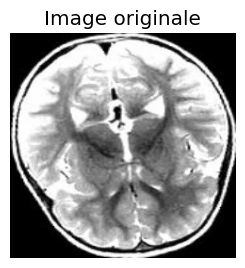

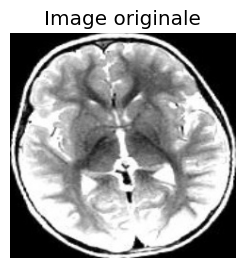

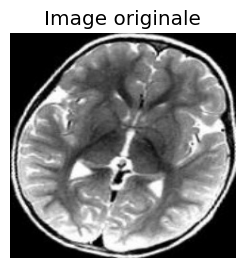

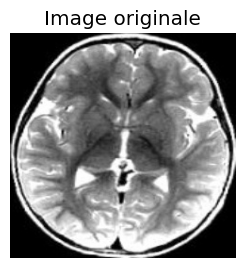

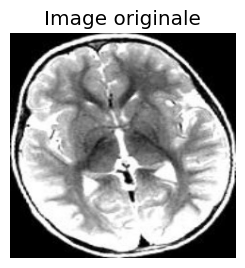

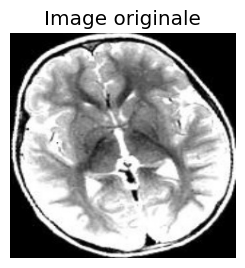

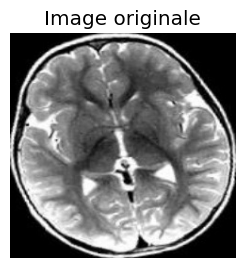

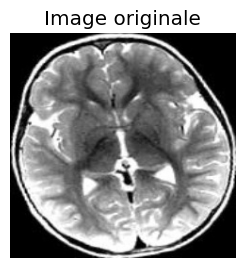

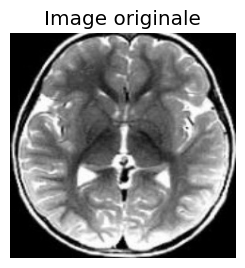

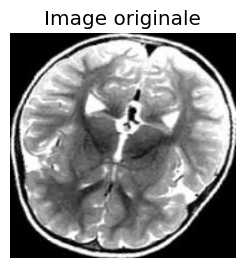

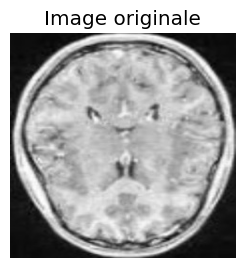

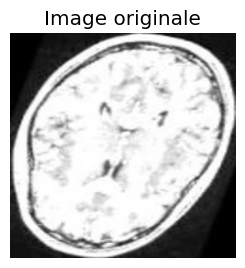

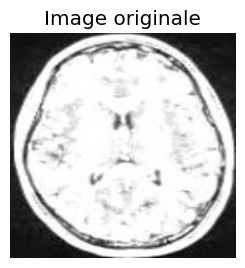

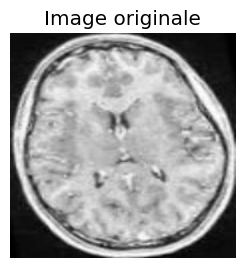

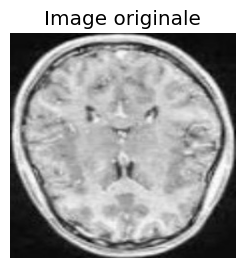

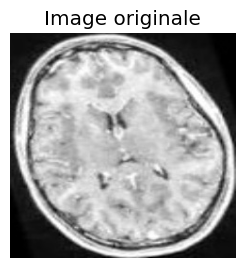

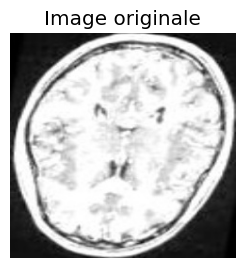

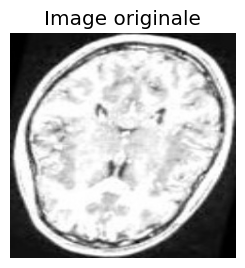

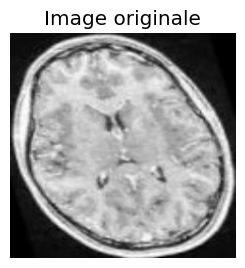

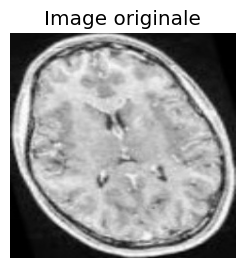

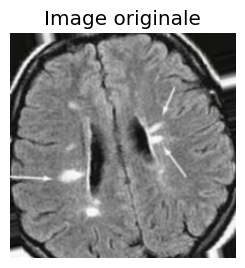

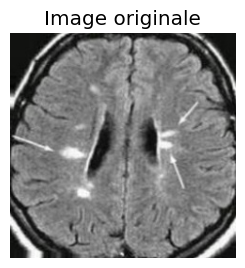

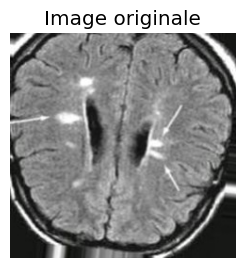

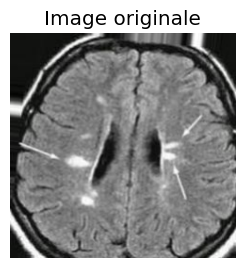

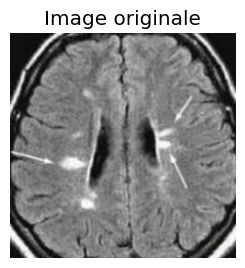

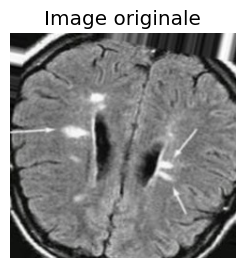

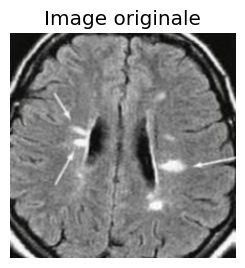

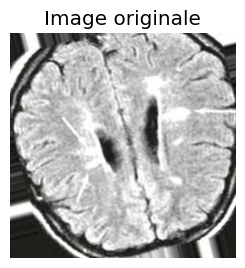

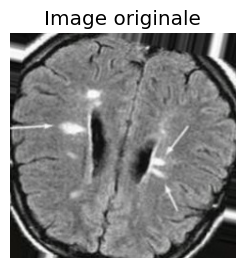

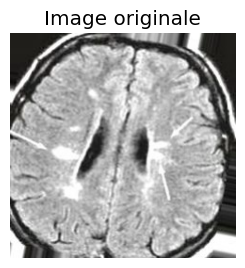

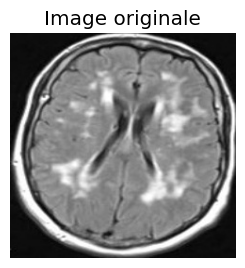

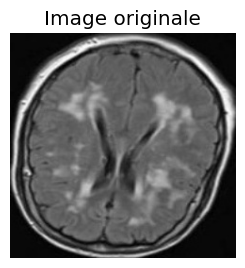

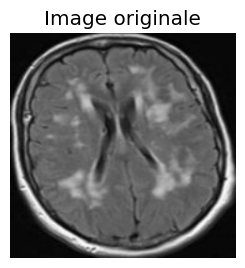

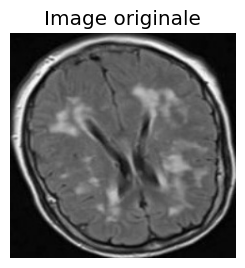

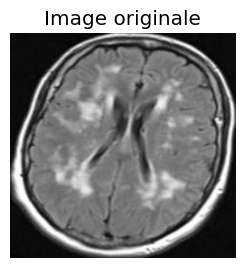

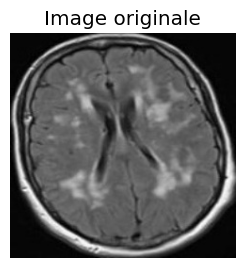

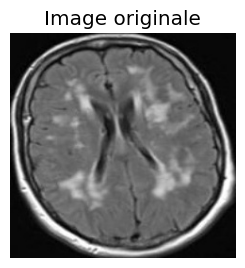

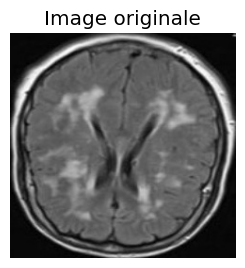

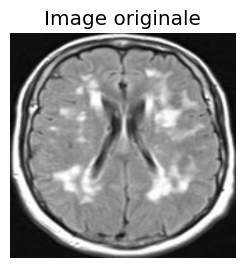

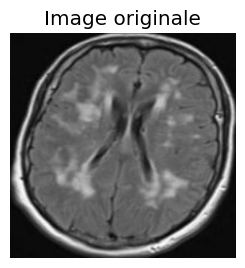

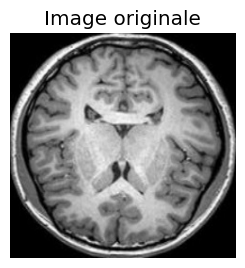

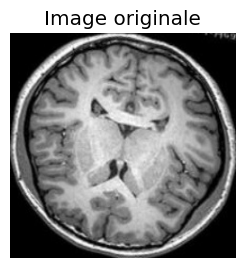

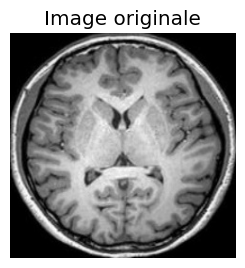

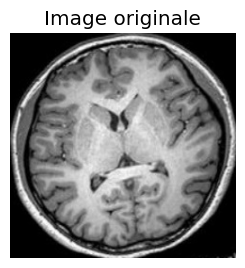

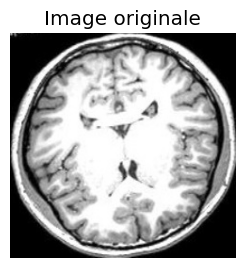

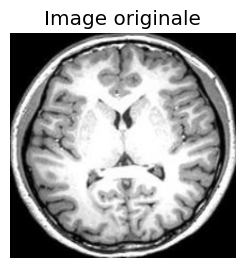

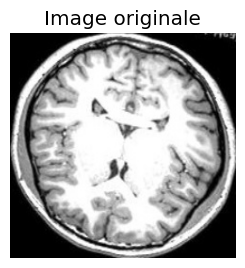

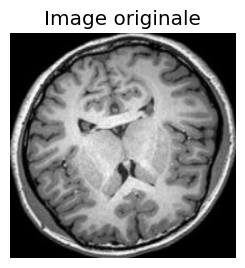

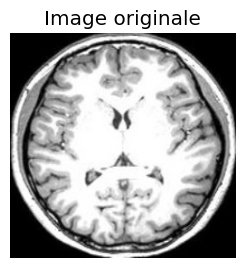

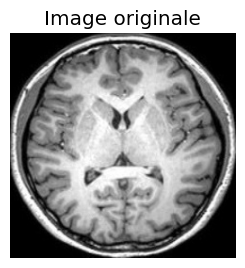

In [64]:
import matplotlib.pyplot as plt

i=0
path='tumorous_and_nontumorous/train/nontumorous/'
for img in os.listdir(path):

    i+=1
    img=cv2.imread(path+img)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Image originale')
    plt.axis('off')
    plt.show()
    if i >= 50:
                break


In [ ]:

img2=cv2.imread('tumorous_and_nontumorous/train/nontumorous/aug_1 no._0_499.jpg')
height, width, channels = img2.shape

print(f"Width: {width}, Height: {height}, Channels: {channels}")

In [ ]:
#load images

In [ ]:
!pip install scikit-learn


In [ ]:
from sklearn.utils import shuffle 
def load_data(dir_list,image_size):
    X=[]
    y=[]
    
    image_width,image_height=image_size
    
    for directory in dir_list :
        for filename in os.listdir(directory):
            image=cv2.imread(directory+ '/'+filename)
            image=crop_brain_tumor(image,plot=False)
            image=cv2.resize(image,dsize=(image_width,image_height),interpolation=cv2.INTER_CUBIC)
            image=image/255.00
            X.append(image)
            if directory[-3:]=="yes":
                y.append(1)
            else:
                y.append(0)
    
    X=np.array(X ,dtype=np.float32)
    y=np.array(y)

    X,y=shuffle(X,y)
    print (f"number of examples is {len(X)}")
    print (f"X shape {X.shape}")
    print (f"y shape {y.shape}")
    return X,y
    

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
X,

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp


# Check the sizes
print("Training set size:", len(X_train), "Validation set size:", len(X_val), "Test set size:", len(X_test))


In [ ]:
augmented_data='augmented_data/'
augmented_yes=augmented_data +'yes'
augmented_no=augmented_data +'no'
IMAGE_WIDTH,IMAGE_HEIGHT=(240,240)
X,y=load_data([augmented_yes,augmented_no],(IMAGE_WIDTH,IMAGE_HEIGHT))

In [ ]:
import tensorflow as tf

# List available physical devices
physical_devices = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(physical_devices)}")

In [ ]:
#data Spliting
#train
#test
#Validation

In [ ]:
if not os.path.isdir('tumorous and nontumorous'):
    base_dir='tumorous_and_nontumorous'
    os.mkdir(base_dir)
    

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir ,'train')
    os.mkdir(train_dir)

if not os.path.isdir('nontumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)

if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

        

In [79]:
original_dataset_tumorous=os.path.join('Brain_Tumor_Detection','yes')
original_dataset_non_tumorous=os.path.join('Brain_Tumor_Detection','no')
train=os.path.join('tumorous_and_nontumorous','train')
intected_train_dir=os.path.join(train,'yes')
test=os.path.join('tumorous_and_nontumorous','test')
intected_test_dir=os.path.join(test,'yes')
valid=os.path.join('tumorous_and_nontumorous','valid')
intected_valid_dir=os.path.join(valid,'yes')




In [ ]:
#COPY

In [25]:
original_data_dir = 'tumorous_and_nontumorous/train/tumorous/'
augmented_data_dir = 'tumorous_and_nontumorous/train/yes/'


for img in os.listdir(original_data_dir):
    original_path = os.path.join(original_data_dir, img)
    target_path = os.path.join(augmented_data_dir, img)
    shutil.copy(original_path, target_path)
print("everything is good Mahmoud")

everything is good Mahmoud


In [228]:
import os
import shutil

# Define the path to the directory you want to delete
dir_to_delete = 'Brain_Tumor_Detection/yes/.ipynb_checkpoints'

# Check if the directory exists
if os.path.exists(dir_to_delete):
    # Delete the directory and all its contents
    shutil.rmtree(dir_to_delete)
    print(f"Directory '{dir_to_delete}' has been deleted successfully.")
else:
    print(f"Directory '{dir_to_delete}' does not exist.")


Directory 'Brain_Tumor_Detection/yes/.ipynb_checkpoints' has been deleted successfully.


In [80]:
files=os.listdir('Brain_Tumor_Detection/yes/')
fnames=[]
for i in range (300,1200):
    fnames.append(files[i])
for fname in fnames:
    src=os.path.join(original_dataset_tumorous,fname)
    dst=os.path.join(intected_train_dir,fname)
    shutil.copyfile(src,dst)

In [86]:
files=os.listdir('Brain_Tumor_Detection/yes/')
fnames=[]
for i in range (1200,1350):
    fnames.append(files[i])
for fname in fnames:
    src=os.path.join(original_dataset_tumorous,fname)
    dst=os.path.join(intected_test_dir,fname)
    shutil.copyfile(src,dst)

In [89]:
files=os.listdir('Brain_Tumor_Detection/yes/')
fnames=[]
for i in range (1350,1500):
    fnames.append(files[i])
for fname in fnames:
    src=os.path.join(original_dataset_tumorous,fname)
    dst=os.path.join(intected_valid_dir,fname)
    shutil.copyfile(src,dst)

In [90]:
train=os.path.join('tumorous_and_nontumorous','train')
healthy_train_dir=os.path.join(train,'no')
test=os.path.join('tumorous_and_nontumorous','test')
healthy_test_dir=os.path.join(test,'no')
valid=os.path.join('tumorous_and_nontumorous','valid')
healthy_valid_dir=os.path.join(valid,'no')



In [91]:
files=os.listdir('Brain_Tumor_Detection/no/')
fnames=[]
for i in range (300,1200):
    fnames.append(files[i])
for fname in fnames:
    src=os.path.join(original_dataset_non_tumorous,fname)
    dst=os.path.join(healthy_train_dir,fname)
    shutil.copyfile(src,dst)

In [ ]:
L= os.listdir('tumorous_and_nontumorous/train/tumorous')
test=len(L)
print(test)

In [ ]:
im

In [105]:
files=os.listdir('Brain_Tumor_Detection/no/')
fnames=[]
for i in range (0,150):
    fnames.append(files[i])
for fname in fnames:
    src=os.path.join(original_dataset_non_tumorous,fname)
    dst=os.path.join(healthy_test_dir,fname)
    shutil.copyfile(src,dst)

In [100]:
files=os.listdir('Brain_Tumor_Detection/no/')
fnames=[]
for i in range (1350,1500):
    fnames.append(files[i])
for fname in fnames:
    src=os.path.join(original_dataset_non_tumorous,fname)
    dst=os.path.join(healthy_valid_dir,fname)
    shutil.copyfile(src,dst)

In [15]:
import cv2
import numpy as np

def preprocess_and_resize(image, target_size=(240, 240)):
    try:
        if image is None:
            raise ValueError("Invalid image, skipping...")

        # Directly resize the image to the target size
        resized_image = cv2.resize(image, target_size)
        
        return resized_image

    except Exception as e:
        print(f"Error processing image: {e}")
        return None



In [48]:
folder1='Brain_Tumor_Detection/no/'
folder2='Brain_Tumor_Detection/yes/'

for filname in  os.listdir(folder1):
    img=cv2.imread(folder1+filname)
    img= preprocess_and_resize(img,target_size=(240, 240))
    cv2.imwrite(folder1+filname,img)
for filname in  os.listdir(folder2):
    img=cv2.imread(folder2+filname)
    img= preprocess_and_resize(img,target_size=(240, 240))
    cv2.imwrite(folder2+filname,img)

In [ ]:

import matplotlib.pyplot as plt
from PIL import Image


# Load the image
image_path = 'tumorous_and_nontumorous/train/tumorous/aug_y0_0_1649.jpg' # replace with your image file path
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()


In [192]:
import os
import cv2

# Function to check and delete invalid images
def delete_invalid_images(directory):
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        try:
            # Attempt to load the image
            image = cv2.imread(img_path)
            
            # If the image can't be loaded or is None, it's invalid
            if image is None:
                print(f"Invalid image: {filename}. Deleting...")
                os.remove(img_path)
            else:
                print(f"Valid image: {filename}")
                
        except Exception as e:
            # Catch any exceptions during loading
            print(f"Error processing image {filename}: {e}")
            print(f"Deleting {filename}...")
            os.remove(img_path)

# Example usage
delete_invalid_images('Brain_Tumor_Detection/no/')


Valid image: no10.jpg
Valid image: no100.jpg
Valid image: no1000.jpg
Valid image: no1001.jpg
Valid image: no1002.jpg
Valid image: no1003.jpg
Valid image: no1004.jpg
Valid image: no1005.jpg
Valid image: no1006.jpg
Valid image: no1007.jpg
Valid image: no1008.jpg
Valid image: no1009.jpg
Valid image: no101.jpg
Valid image: no1010.jpg
Valid image: no1011.jpg
Valid image: no1012.jpg
Valid image: no1013.jpg
Valid image: no1014.jpg
Valid image: no1015.jpg
Valid image: no1016.jpg
Valid image: no1017.jpg
Valid image: no1018.jpg
Valid image: no1019.jpg
Valid image: no102.jpg
Valid image: no1020.jpg
Valid image: no1021.jpg
Valid image: no1022.jpg
Valid image: no1023.jpg
Valid image: no1024.jpg
Valid image: no1025.jpg
Valid image: no1026.jpg
Valid image: no1027.jpg
Valid image: no1028.jpg
Valid image: no1029.jpg
Valid image: no103.jpg
Valid image: no1030.jpg
Valid image: no1031.jpg
Valid image: no1032.jpg
Valid image: no1033.jpg
Valid image: no1034.jpg
Valid image: no1035.jpg
Valid image: no1036.jp

In [ ]:
def resize_images_in_directory(directory, target_size=(240, 240)):
  
    for filename in os.listdir(directory):
    
            file_path = os.path.join(directory, filename)

            
            img = cv2.imread(file_path)

            # Resize the image to the target size
            resized_image = cv2.resize(img, dsize=target_size, interpolation=cv2.INTER_CUBIC)

            # Save the resized image back to the same file path (overwrite)
            return resized_image

           


In [ ]:
# Enable the strategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

# Print the number of devices being used
print(f'Number of devices: {strategy.num_replicas_in_sync}')


In [ ]:
#model building

In [140]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.applications.vgg16 import VGG16, preprocess_input
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)



   

# Test data augmentation (only rescaling)
test_data_gen = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_input)

# Validation data augmentation (only rescaling)
valid_data_gen = ImageDataGenerator(rescale=1./255)

In [111]:
train_generator=train_datagen.flow_from_directory('tumorous_and_nontumorous/train/' ,batch_size=32,target_size=(240,240),class_mode='binary', shuffle=True,seed=42,color_mode='rgb')



Found 1800 images belonging to 2 classes.


In [112]:
test_generator=test_data_gen.flow_from_directory('tumorous_and_nontumorous/test/' ,batch_size=16,target_size=(240,240),class_mode='binary', shuffle=True,seed=42,color_mode='rgb')

Found 600 images belonging to 2 classes.


In [124]:
valid_generator=valid_data_gen.flow_from_directory('tumorous_and_nontumorous/valid/' ,batch_size=8,target_size=(240,240),class_mode='binary', shuffle=True,seed=42,color_mode='rgb')

Found 600 images belonging to 2 classes.


In [81]:
class_labels=train_generator.class_indices
class_name={value:key for (key,value)in class_labels.items()}

In [70]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [114]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

base_Neural_Net= VGG19(input_shape=(240,240,3), weights='imagenet', include_top=False)
model_01=Sequential()
model_01.add(base_Neural_Net)
model_01.add(Flatten())
model_01.add(BatchNormalization())
model_01.add(Dense(256,kernel_initializer='he_uniform'))
model_01.add(BatchNormalization())
model_01.add(Activation('relu'))
model_01.add(Dropout(0.5))
model_01.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

# Compile the model with Adam optimizer
adam = Adam(learning_rate=0.001)  # Use Adam optimizer with a small learning rate
model_01.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# Model summary to inspect the architecture
model_01.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,548,801 (101.28 MB)

 Trainable params: 6,473,729 (24.70 MB)

 Non-trainable params: 20,075,072 (76.58 MB)

In [115]:
#callback
filepath='model.keras'
es=EarlyStopping(monitor='val_loss',verbose=1,mode='min',patience=5)
cp=ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False,mode='auto',save_freq='epoch')
lrr=ReduceLROnPlateau(monitor='val_accuracy', patience=3,verbose=1,factor=0.5,min_lr=0.0001)

In [116]:


history_01 = model_01.fit( train_generator, epochs=30,callbacks = [es, cp, lrr], validation_data=valid_generator,verbose=1 )


/anaconda/envs/my_new_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.7236 - loss: 0.7108
Epoch 1: val_loss improved from inf to 0.27789, saving model to model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7249 - loss: 0.7068 - val_accuracy: 0.9267 - val_loss: 0.2779 - learning_rate: 0.0010
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.8925 - loss: 0.2776
Epoch 2: val_loss improved from 0.27789 to 0.25633, saving model to model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8925 - loss: 0.2777 - val_accuracy: 0.9367 - val_loss: 0.2563 - learning_rate: 0.0010
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.8983 - loss: 0.2423
Epoch 3: val_loss improved from 0.25633 to 0.18643, saving model to model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8984 - loss: 0.2421 - val_accuracy: 0.9600 - val_loss: 0.1864 - learning_rate: 0.0010
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.9151 - loss: 0.2230
Epo

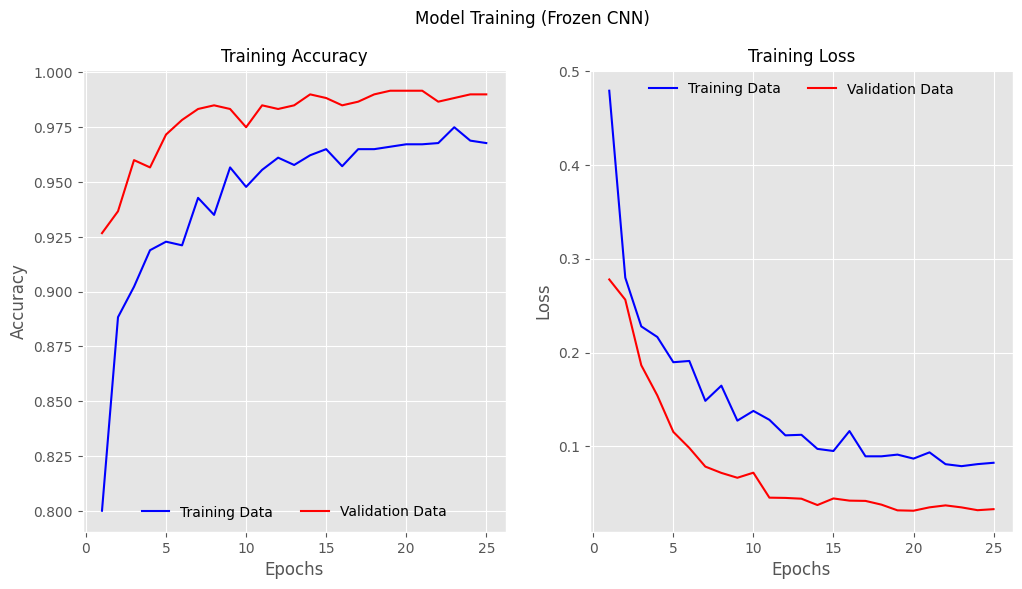

In [117]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)

# Calculate the number of epochs
max_epoch = len(history_01.history['accuracy']) + 1
epochs_list = list(range(1, max_epoch))

# Plot training and validation accuracy
ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

# Plot training and validation loss
ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)

# Save the figure
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')
plt.show()  # Optional: To display the plot


In [75]:
# Check training history contents
print("Training Accuracy: ", history_01.history['accuracy'])
print("Validation Accuracy: ", history_01.history['val_accuracy'])
print("Training Loss: ", history_01.history['loss'])
print("Validation Loss: ", history_01.history['val_loss'])


Training Accuracy:  [0.9018011689186096, 0.9463110566139221, 0.95778489112854, 0.9604693651199341, 0.96731036901474, 0.967873215675354, 0.9711205363273621, 0.9762296676635742, 0.9791305661201477, 0.9809923768043518, 0.981468677520752, 0.9822480082511902, 0.9854087233543396, 0.9868375658988953]
Validation Accuracy:  [0.9577777981758118, 0.9866666793823242, 0.9866666793823242, 0.9933333396911621, 0.9888888597488403, 0.9888888597488403, 0.9888888597488403, 0.9933333396911621, 0.9977777600288391, 0.995555579662323, 0.9933333396911621, 0.995555579662323, 0.9933333396911621, 0.995555579662323]
Training Loss:  [0.24270351231098175, 0.13923008739948273, 0.11427310854196548, 0.10335633158683777, 0.08964656293392181, 0.09017911553382874, 0.0784522294998169, 0.06623534113168716, 0.05765386298298836, 0.05400519818067551, 0.05108517408370972, 0.049393873661756516, 0.042488910257816315, 0.038878317922353745]
Validation Loss:  [0.11317417770624161, 0.05379389971494675, 0.04560337960720062, 0.03555544

In [75]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath="model_weights/vgg19_model_01.weights.h5",overwrite=True)


In [76]:
model_01.load_weights("model_weights/vgg19_model_01.weights.h5")
vgg_val_eval_01=model_01.evaluate(valid_generator)
vgg_test_eval_01=model_01.evaluate(test_generator)


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 1.0000 - loss: 0.0090
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 493ms/step - accuracy: 0.9876 - loss: 0.0258


In [ ]:
print(vgg_val_eval_01[0])
print(vgg_val_eval_01[1])
print(vgg_test_eval_01[0])
print(vgg_test_eval_01[1])

In [77]:
filenames=test_generator.filenames
nb_sample=(len(filenames) + test_generator.batch_size - 1) // test_generator.batch_size

test_loss, test_accuracy = model_01.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}")




15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 436ms/step - accuracy: 0.9871 - loss: 0.0256
Test accuracy: 0.9933333396911621


38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 297ms/step
Test Accuracy = 0.50


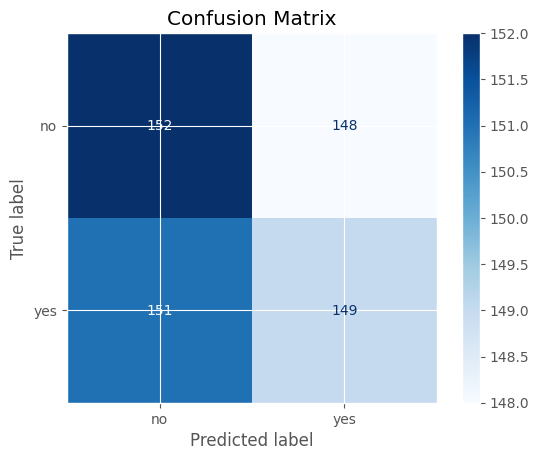

In [125]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('model.keras')

# Generate predictions using the test generator
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert probabilities to binary predictions (0 or 1)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Extract actual labels from the generator for comparison
y_test_actual = test_generator.classes  # Assuming binary classes (0 or 1)

# Calculate accuracy
accuracy = accuracy_score(y_test_actual, predictions)
print('Test Accuracy = %.2f' % accuracy)

# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_test_actual, predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()




In [121]:

import cv2
import numpy as np



img = cv2.imread('Brain_Tumor_Detection/pred/pred0.jpg')
resized_image = cv2.resize(img, dsize=(240, 240), interpolation=cv2.INTER_CUBIC)
resized_image = np.expand_dims(resized_image, axis=0)  # Shape becomes (1, 240, 240, 3)
predictions = model_01.predict(resized_image)
predictions
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[1.]], dtype=float32)

In [154]:

import cv2
import numpy as np

L=[]
test='Brain_Tumor_Detection/no/'
for img in os.listdir(test):
    img = cv2.imread(test+img)
    resized_image = cv2.resize(img, dsize=(240, 240), interpolation=cv2.INTER_CUBIC)
    resized_image = np.expand_dims(resized_image, axis=0)  # Shape becomes (1, 240, 240, 3)
    predictions = model_01.predict(resized_image)
    if  predictions[0][0] < 0.5:
        L.append(0)
    else:
       L.append(1) 
print(L)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [170]:
L.count(1)

675